# Using Numerical and Categorical Variables Together

In this notebook we will show how to combine numerical and categorical variables together.  

In [1]:
import pandas as pd 

df = pd.read_csv('data/adult-census.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [2]:
target = df['class']
data = df.drop(columns=['fnlwgt', 'education', 'class'])

## Selection Based on Data types

We need first to separate categorical and numerical variables using their data types to identify them. We make use of `make_column_selector` helper to select the corresponding columns.

In [3]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

## Dispatch Columns to a Specific Processor

Scikit-learn provides a `ColumnTransform` class which will send specific columns to a specific transformer, making it easy to fit a single predictive model on a dataset that combines both kind of variables together (heterogeneously typed tabular data).

We first define the columns depending on their data type:

  * **one-hot encoding** will be applied to categorical columns. Besides, we use `handle_unknown="ignore"` to solve the potential issues due to rare categories.

  * **numerical scaling** numerical features which will be standardized.


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [5]:
categorical_prep = OneHotEncoder(handle_unknown='ignore')
numerical_prep = StandardScaler()

Now, we create the transformer and associate each of these preprocessors with their respective columns.

In [6]:
from sklearn.compose import ColumnTransformer

In [7]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_prep, categorical_columns),
    ('standard-scaler', numerical_prep, numerical_columns)])

The structure of a `ColumnTransformer`:

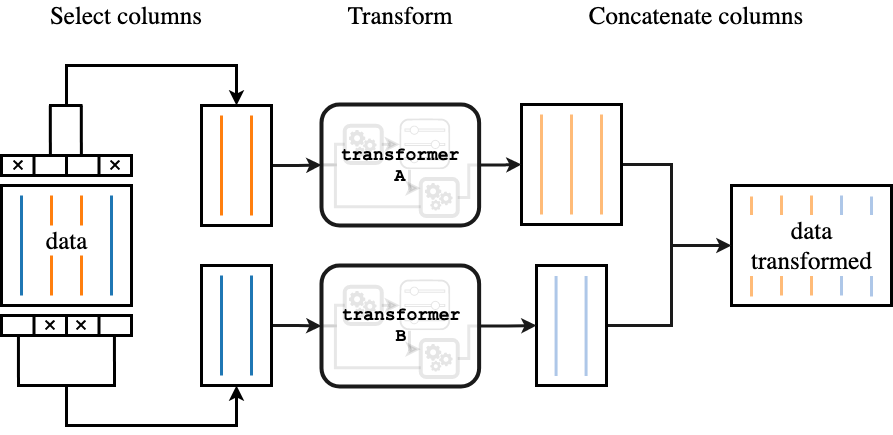

A `ColumnTransformer` does the following:

* It splits the columns of the original dataset based on the column names or indices provided. We will obtain as many subsets as the number of transormers passed into the `ColumnTransformer`.
* It transforms each subsets. A specific transformer is applied to each subset: it will internally call `fit_transform` or `transform`. The output of this step is a set of transformed datasets.
* It then concatenates the transformed datasets into a single dataset.


The important thing is that `ColumnTransformer` is like any other scikit-learn transformer. In particular it can be compined with a classifier in a pipeline:

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

We can display an interactive diagram with the following command:

In [9]:
from sklearn import set_config

set_config(display = 'diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

The final model ismore complex than the previous models but still follows the same API:

* The `fit` mehod is called to preprocess the data and then train the classsifier of the preprocessed data;
* The `predict` method makes predictions on new data;
* The `score` method is used to predict on the test data and compare the predictions to the expected test labels to compute the accuracy.

Let's start by splitting our data into train and test sets.

In [10]:
from sklearn.model_selection import train_test_split

In [13]:
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                                    test_size=.25, 
                                                                    random_state=23)

In [15]:
model.fit(data_train, target_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

Then, we can send the raw dataset straingt to the pipeline. Indeed, we do not need to make any manual preprocessing (calling the `transform` or `fit_transform` methods) as it will be handled when calling the predict method.

In [16]:
data_test.head()
model.predict(data_test)[:5]

array([' <=50K', ' <=50K', ' <=50K', ' <=50K', ' <=50K'], dtype=object)

In [18]:
print(target_test[:5])

10923     <=50K
48457     <=50K
19854     <=50K
9806      <=50K
8932      <=50K
Name: class, dtype: object


To get directly the accuracy score, we need to call the `score` method. Let's compute the accuracy on the entire test set.

In [19]:
model.score(data_test, target_test)

0.8554581934321513

## Evaluation of the Model with Cross-Validation

As previously stated, a predictive model should be evaluated by cross-validation. Our model is usable with the cross-validation tools of scikit-learn as any other predictors.

In [20]:
from sklearn.model_selection import cross_validate

In [21]:
res = cross_validate(model, data, target, cv=5)
res

{'fit_time': array([1.61125398, 1.32790303, 1.28511477, 1.57070112, 1.57856894]),
 'score_time': array([0.05559897, 0.05531406, 0.05624509, 0.05585504, 0.055897  ]),
 'test_score': array([0.85065002, 0.8515713 , 0.84879197, 0.85421785, 0.85534398])}

In [22]:
scores = res['test_score']
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.852 +/- 0.002


The compound model has a higher predictive accuracy than the two models that used numerical and categorical variables in isolation.

## Fitting a more Powerful Model

Linear models are nice because they are ususaly cheap to train, small, fast to predict and give a good baseline.

However, it is often useful to check whether more complex models such as an ensemble of decision trees can lead to higher predictive performance. In this section we will use such a model called **gradient-boosting trees** and evaluate its generalization performance. More precisely, the scikit-learn model we will use is called `HistGradientBoostingClassifier`. Note that boosting models will covered in more detail in a future module.

For tree-based models, the handling of numerical and categorical variables is simpler that for linear models:

* we do not need to scale the numerical features
* using an ordinal encoding for the categorical variables is fine even if the encoding results in an arbitrary ordering

Therefore, for `HistGradientBoostingClassifier`, the preprocessing pipeline is slightly simpler than the one we saw earlier for the `LogisticRegression`:

In [24]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

categorical_prep = OrdinalEncoder(handle_unknown="use_encoded_value",
                                 unknown_value=-1)
preprocessor = ColumnTransformer([
    ('categorical', categorical_prep, categorical_columns)],
    remainder='passthrough')
model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

Now that we created our model, we can check its generalization performance.

In [25]:
%%time
model.fit(data_train, target_train)

CPU times: user 4.18 s, sys: 417 ms, total: 4.6 s
Wall time: 2.07 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [26]:
model.score(data_test, target_test)

0.8760134305134715

We see that we get significantly higher accuracies with the Gradient Boosting model. This is often what we observe whenever the dataset has a large number of samples and limited number of informative features (e.g less than 1000) with a mix of numberical and categorical variables.

This explains why Gradien Bossted Machines are very popular amond datascience practitioners.

## Wrap Up

In this module, we learned:

* to create a scikit-learn predictive model;
* about the scikit-learn API to train and test a predictive model;
* to process numerical data, notably using a `Pipeline`
* to process categorical data, notably using a `OneHotEncoder` and an `OrdinalEncoder`;
* to handle and process mixed data types (i.e. numerical and categorical data), notably using `ColumnTransformer`